<center>
    <H1>DATA7703, Week 6 Practical Solutions</H1>
    <b>2023 Semester 2</b>
</center>    

## Q1. Training neural networks for OLS

**(a)** We generate the data using the `regression_data` function provided in the lecture slides as follows.

In [1]:
import torch

def regression_data(n=500, d=2):
    X = torch.rand(n, d)
    w = torch.rand(d+1)
    Y = X @ w[1:] + w[0] + torch.rand(n) * 0.1
    return X, Y

torch.manual_seed(1)
X, Y = regression_data(n=200, d=2)

Following the example at https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html, we can generate a 3D scatter plot for the data as shown below.

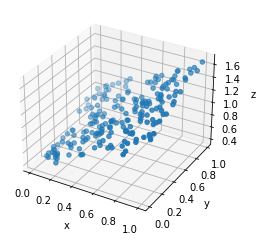

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], Y)
ax.set(xlabel='x', ylabel='y', zlabel='z')
plt.show()

To view the scatter plot from a different angle, one way is to follow the instruction in the question: put the above code in a separate python file, and then run it, then you can rotate the plot to visualize it from angle you want.

Alternatively, we can view the scatter plot from another angle using the `view_init` function. For example, the following code allows us to view the plot from the direction obtained by rotating the $x$ axis counterclockwise by 20 degrees around the $z$ axis (i.e., azimuth is 20 degrees), and then rotating it upward by 30 degrees (i.e., elevation is 30 degrees).  

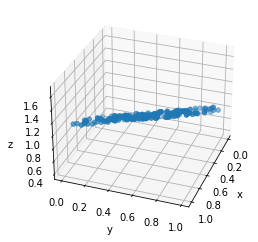

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], Y)
ax.set(xlabel='x', ylabel='y', zlabel='z')
ax.view_init(elev=30, azim=20)
plt.show()

It's clear that the points roughly lie on a plane from this view.

**(b)** From the documentation of the `LinearRegression` at https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html, the bias and coefficients of the fitted OLS model is shown below.

In [4]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X, Y)
reg.intercept_, reg.coef_ 

(0.29468215, array([0.8489191, 0.5036463], dtype=float32))

**(c)** Model obtained using the first approach is shown below.

In [5]:
def ols1(X, Y):
    X = torch.cat([torch.ones(X.shape[0], 1), X], dim=1) # add 1
    w = torch.zeros(X.shape[1], requires_grad=True)
    for i in range(200):
        loss = torch.mean((X @ w - Y)**2)
        if w.grad is not None:
            w.grad.zero_() # important: reset the stored gradient to 0
        loss.backward()
        w.data.add_(-0.5*w.grad.data)
    print(w)

In [6]:
ols1(X, Y)

tensor([0.2947, 0.8489, 0.5036], requires_grad=True)


Model obtained using the second approach is shown below.

In [7]:
import torch.optim as optim
from torch.autograd import Variable

def ols2(X, Y):
    X = torch.cat([torch.ones(X.shape[0], 1), X], dim=1) # add 1
    w = Variable(torch.zeros(X.shape[1]), requires_grad=True)
    optimizer = optim.SGD([w], lr=0.5, momentum=0)
    for i in range(200):
        optimizer.zero_grad()
        loss = torch.mean((X @ w - Y)**2)
        loss.backward()
        optimizer.step()
    print(w)

In [8]:
ols2(X, Y)

tensor([0.2947, 0.8489, 0.5036], requires_grad=True)


Model obtained using the third approach is shown below.

In [9]:
import torch.optim as optim
import torch.nn as nn
from torch.nn.modules.loss import MSELoss

def ols3(X, Y, niter=200, lr=0.5):
    Y = Y.reshape(-1, 1)
    net = nn.Linear(2, 1)
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0)
    mse = MSELoss()
    for i in range(niter):
        optimizer.zero_grad()
        loss = mse(net(X), Y)
        loss.backward()
        optimizer.step()
    for param in net.parameters():
        print(param)

In [10]:
ols3(X, Y)

Parameter containing:
tensor([[0.8489, 0.5036]], requires_grad=True)
Parameter containing:
tensor([0.2947], requires_grad=True)


All of the three models are the same as the one in (b), indicating that gradient descent works well on this dataset.

**(d)** When we use a learning rate of 0.01, the trained model has different parameters than those above. This indicates that gradient descent may have not converged yet. 

In [11]:
ols3(X, Y, lr=0.01)

Parameter containing:
tensor([[0.7567, 0.8536]], requires_grad=True)
Parameter containing:
tensor([0.1560], requires_grad=True)


Indeed, if we increase the number of iterations to 10000, we get the same model as in (b) and (c).

In [12]:
ols3(X, Y, niter=10000, lr=0.01)

Parameter containing:
tensor([[0.8489, 0.5036]], requires_grad=True)
Parameter containing:
tensor([0.2947], requires_grad=True)


When we use a learning rate of 0.1, the trained model seems the same as those in (b) and (c).

In [13]:
ols3(X, Y, lr=0.1)

Parameter containing:
tensor([[0.8030, 0.4704]], requires_grad=True)
Parameter containing:
tensor([0.3374], requires_grad=True)


When we use a learning rate of 1, gradient descent diverges and we don't get a valid model.

In [14]:
ols3(X, Y, lr=1)

Parameter containing:
tensor([[nan, nan]], requires_grad=True)
Parameter containing:
tensor([nan], requires_grad=True)


The above results confirm that the choice of learning rate is important, as discussed in lecture.

## Q2. Convolutional filters
**(a)** To compute the convolution, we simply slide the 2D filter matrix through the 3D input input array, and compute the inner product between filter matrix and the sub-arrays encountered. The required function is implemented as follows.

In [15]:
def conv(image, kernel):
    H, W, C = image.shape
    kH, kW = kernel.shape
    
    output = np.zeros((H-kH+1, W-kW+1, C))
    for i in range(H-kH+1): # loop through rows
        for j in range(W-kW+1): # loop through columns
            for k in range(C): # loop through channels
                output[i, j, k] = (image[i:(i+kH), j:(j+kW), k] * kernel).sum()
    return output

(b) 

Images size: (512, 512, 3)


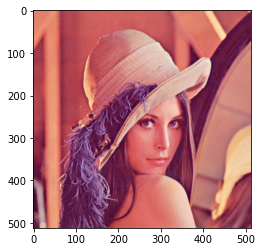

In [16]:
import matplotlib.pyplot as plt
lenna = plt.imread('lenna.png')
print('Images size:', lenna.shape)
plt.imshow(lenna)
plt.show()

(c) The result of applying the filter to the Lenna image is shown below. Note that the output has negative values and values larger than 1. The warning message indicates that `imshow` clips the values to [0, 1] before showing the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


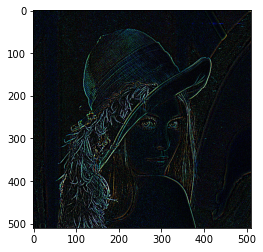

In [17]:
kernel =  np.array([[-1,  -1,  -1],
        [-1,  8,  -1],
        [-1,  -1,  -1]])
lenna1 = conv(lenna, kernel)
plt.imshow(lenna1)
plt.show()

(d) The 2D array is shown below. 1 is shown as white pixel and 0 as black. From (c) and (d), it's clear that the convolutional filter in (c) makes pixels on an edge stand out, and makes other non-edge pixels close to 0.

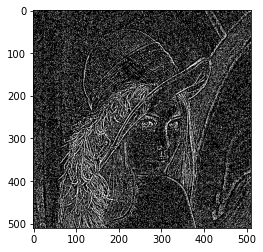

In [18]:
r, g, b = lenna1[:, :, 0], lenna1[:, :, 1], lenna1[:, :, 2]
o = (r > r.mean()) & (g > g.mean()) & (b > b.mean()) # threshold the RGB values separately
plt.imshow(o, cmap='gray')
plt.show()